In [1]:
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt
from recurrent_kernel import recurrent_kernel, erf_kernel, weighted_dot, update_fn, diagonal_update_fn, train, predict
from jax.lax import scan

%config InlineBackend.figure_format = 'svg'

In [2]:
# Data
data_train = jnp.load('u_train.npy')
data_test = jnp.load('u_test.npy')
data_full = jnp.concatenate([data_train, data_test])

# These are the baselines from explicit reservoirs
K_baseline_train = jnp.load('K_baseline_train.npy')
K_baseline_test = jnp.load('K_baseline_test.npy')
K_baseline_full = jnp.concatenate([K_baseline_train, K_baseline_test], axis=0)

# This is the explicit reservoir run over all data
K_true = jnp.load('K_true.npy')

In [3]:
scaling = (0.4, 0.9, 0.4)
renorm = 0.11
alpha = 1e-2
N_train = 10000
N_init = 50
dot_fn = weighted_dot(*scaling)

Let's try and plot the train error as a function of only sigma_i:

In [4]:
@jax.jit
def train_error(sigma_i):
    # Running model
    K_train, uu = recurrent_kernel(data_train, erf_kernel, (sigma_i, 0.9, 0.4))
    W_out = train(K_train, data_train, alpha, renorm, n_init=N_init)
    
    # Predict on train set
    K_train = K_train[N_init:, N_init:]
    K_train += renorm * jnp.dot(data_train[N_init - 1 : -1], data_train[N_init - 1 : -1].T)
    y = jnp.dot(K_train, W_out)
    
    # Error 
    loss = jnp.mean((y - data_train[N_init:, :])**2)
    return loss

In [5]:
%%time
sigma_i = jnp.linspace(0, 5, 50)
MSE = [train_error(sigma) for sigma in sigma_i]

CPU times: user 12.7 s, sys: 1.96 s, total: 14.6 s
Wall time: 14.3 s


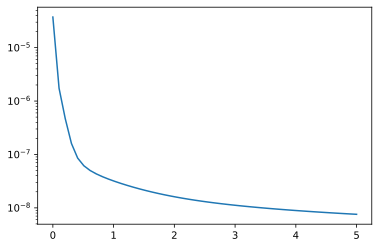

In [6]:
plt.semilogy(sigma_i, MSE)

In [7]:
grad_fn = jax.jit(jax.grad(train_error))

In [8]:
grad_fn(0.4)

DeviceArray(-4.063411e-07, dtype=float32)

In [9]:
@jax.jit
def train_error(sigma_r):
    # Running model
    K_train, uu = recurrent_kernel(data_train, erf_kernel, (0.4, sigma_r, 0.4))
    W_out = train(K_train, data_train, alpha, renorm, n_init=N_init)
    
    # Predict on train set
    K_train = K_train[N_init:, N_init:]
    K_train += renorm * jnp.dot(data_train[N_init - 1 : -1], data_train[N_init - 1 : -1].T)
    y = jnp.dot(K_train, W_out)
    
    # Error 
    loss = jnp.mean((y - data_train[N_init:, :])**2)
    return loss

In [10]:
%%time
sigma_r = jnp.linspace(0, 5, 50)
MSE = [train_error(sigma) for sigma in sigma_r]

CPU times: user 11.9 s, sys: 1.61 s, total: 13.5 s
Wall time: 13 s


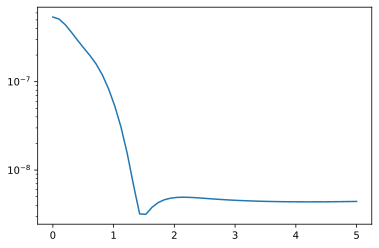

In [19]:
plt.semilogy(sigma_i, MSE)

In [12]:
grad_fn = jax.jit(jax.grad(train_error))

In [17]:
grad_fn(1.4)

DeviceArray(-2.6738348e-08, dtype=float32)

In [37]:
@jax.jit
def train_error(renorm):
    # Running model
    K_train, uu = recurrent_kernel(data_train, erf_kernel, (0.4, 0.9, 0.4))
    W_out = train(K_train, data_train, alpha, renorm, n_init=N_init)
    
    # Predict on train set
    K_train = K_train[N_init:, N_init:]
    K_train += renorm * jnp.dot(data_train[N_init - 1 : -1], data_train[N_init - 1 : -1].T)
    y = jnp.dot(K_train, W_out)
    
    # Error 
    loss = jnp.sum((y - data_train[N_init:, :])**2)
    return loss

In [38]:
%%time
renorm = jnp.linspace(0, 5, 50)
MSE = [train_error(sigma) for sigma in renorm]

CPU times: user 11.8 s, sys: 1.59 s, total: 13.4 s
Wall time: 12.9 s


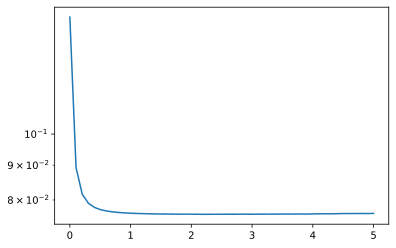

In [39]:
plt.semilogy(sigma_i, MSE)

In [40]:
jnp.argmin(jnp.stack(MSE))

DeviceArray(22, dtype=int32)

Okay lets do a little loop:

In [41]:
grad_fn = jax.jit(jax.grad(train_error))
grad_fn(1.4)

DeviceArray(-0.00030106, dtype=float32)

In [42]:
%%timeit
grad_fn(1.4)

699 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%%time
renorm = 0.0
for _ in jnp.arange(100):
     renorm -= 1e-2 * grad_fn(renorm)

CPU times: user 46.1 s, sys: 23.7 s, total: 1min 9s
Wall time: 1min 9s


In [46]:
renorm

DeviceArray(0.1649953, dtype=float32)